# Similitud entre Productos

**Objetivo**: Determinar cuán similares son dos títulos de productos del dataset de test, generando un listado de pares ordenados por score de similitud.

**Modelo**: SBERT (paraphrase-multilingual-mpnet-base-v2)

**Criterio de filtrado**: Score de similitud >= 0.9

| Dataset | Productos | Uso |
|---------|-----------|-----|
| `items_titles_test.csv` | 10,000 | Evaluación y generación de pares |

---
## 1. Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

from utils_similarity import (
    preprocess_dataframe,
    analizar_longitud_titulos,
    ProductSimilarity,
    reduce_dimensions_3d,
    cluster_embeddings,
    plot_3d_clusters
)

# Configuración
THRESHOLD = 0.9  # Filtrar pares con similitud >= 0.9

print("Setup completado")

Setup completado


---
## 2. EDA - Análisis Exploratorio

In [2]:
# Cargar dataset de test
df_test = pd.read_csv('items_titles_test.csv')

print(f"Dataset TEST: {len(df_test):,} productos")
print(f"Columnas: {df_test.columns.tolist()}")

Dataset TEST: 10,000 productos
Columnas: ['ITE_ITEM_TITLE']


In [3]:
# Muestra de títulos
print("Ejemplos de títulos:")
for i, title in enumerate(df_test['ITE_ITEM_TITLE'].head(10)):
    print(f"  {i+1}. {title}")

Ejemplos de títulos:
  1. Tênis Olympikus Esporte Valente - Masculino Kids
  2. Bicicleta Barra Forte Samy C/ 6 Marchas Cubo C/ Rolamento
  3. Tênis Usthemp Slip-on Temático - Labrador 2
  4. Tênis Casual Feminino Moleca Tecido Tie Dye
  5. Tênis Star Baby Sapatinho Conforto + Brinde
  6. Tênis Oakley Frequency 3.0 Preto/marrom
  7. Tênis Jogging Feminino Premium Super Lançamento Vizzano
  8. Under Armour Hovr Phantom 2 Conexão Bluetooth Tênis Running
  9. Tenis Infantil Feminino Menina Criança Moça
  10. Tênis Labellamafia Saturn 6 Cores Disponíveis


In [4]:
# Estadísticas de longitud
stats = analizar_longitud_titulos(df_test)

print("\nEstadísticas de Longitud de Títulos:")
print(f"  Caracteres: media={stats['char_length']['mean']:.1f}, mediana={stats['char_length']['median']:.0f}")
print(f"  Palabras:   media={stats['word_count']['mean']:.1f}, mediana={stats['word_count']['median']:.0f}")


Estadísticas de Longitud de Títulos:
  Caracteres: media=47.0, mediana=50
  Palabras:   media=7.2, mediana=7


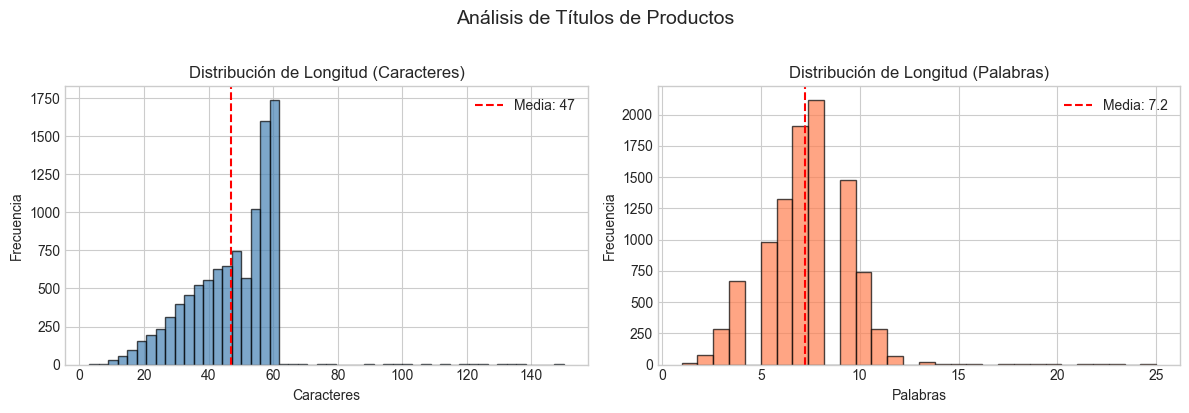

In [5]:
# Distribución de longitudes
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(df_test['ITE_ITEM_TITLE'].str.len(), bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].axvline(stats['char_length']['mean'], color='red', linestyle='--', label=f"Media: {stats['char_length']['mean']:.0f}")
axes[0].set_xlabel('Caracteres')
axes[0].set_ylabel('Frecuencia')
axes[0].set_title('Distribución de Longitud (Caracteres)')
axes[0].legend()

axes[1].hist(df_test['ITE_ITEM_TITLE'].str.split().str.len(), bins=30, edgecolor='black', alpha=0.7, color='coral')
axes[1].axvline(stats['word_count']['mean'], color='red', linestyle='--', label=f"Media: {stats['word_count']['mean']:.1f}")
axes[1].set_xlabel('Palabras')
axes[1].set_ylabel('Frecuencia')
axes[1].set_title('Distribución de Longitud (Palabras)')
axes[1].legend()

plt.suptitle('Análisis de Títulos de Productos', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

---
## 3. Preprocesamiento

In [6]:
# Preprocesar títulos
df_test = preprocess_dataframe(df_test, column='ITE_ITEM_TITLE', output_column='title_clean')

# Mostrar ejemplos antes/después
print("Ejemplos de preprocesamiento:")
for i in range(5):
    print(f"\n  Original:    {df_test['ITE_ITEM_TITLE'].iloc[i]}")
    print(f"  Procesado:   {df_test['title_clean'].iloc[i]}")

Ejemplos de preprocesamiento:

  Original:    Tênis Olympikus Esporte Valente - Masculino Kids
  Procesado:   tênis olympikus esporte valente masculino kids

  Original:    Bicicleta Barra Forte Samy C/ 6 Marchas Cubo C/ Rolamento
  Procesado:   bicicleta barra forte samy c 6 marchas cubo c rolamento

  Original:    Tênis Usthemp Slip-on Temático - Labrador 2
  Procesado:   tênis usthemp slip on temá tico labrador 2

  Original:    Tênis Casual Feminino Moleca Tecido Tie Dye
  Procesado:   tênis casual feminino moleca tecido tie dye

  Original:    Tênis Star Baby Sapatinho Conforto + Brinde
  Procesado:   tênis star baby sapatinho conforto brinde


In [7]:
# Preparar listas
titles_clean = df_test['title_clean'].tolist()
titles_original = df_test['ITE_ITEM_TITLE'].tolist()

print(f"\nTítulos preparados: {len(titles_clean):,}")


Títulos preparados: 10,000


---
## 4. Generación de Embeddings

In [8]:
%%time
# Inicializar modelo SBERT
similarity_model = ProductSimilarity(model_name='sbert')

# Generar embeddings
similarity_model.fit(
    titles=titles_clean,
    titles_original=titles_original,
    batch_size=64,
    show_progress=True
)

embeddings = similarity_model.embeddings
print(f"\nEmbeddings shape: {embeddings.shape}")

Cargando modelo: paraphrase-multilingual-mpnet-base-v2...
Modelo cargado. Dimensión: 768
Generando embeddings para 10,000 productos...


Batches: 100%|██████████| 157/157 [00:17<00:00,  8.76it/s]

Embeddings generados. Shape: (10000, 768)

Embeddings shape: (10000, 768)
CPU times: user 5.24 s, sys: 1.37 s, total: 6.61 s
Wall time: 25 s


---
## 5. Visualización 3D de Clusters

In [9]:
# Reducir dimensiones para visualización
print("Reduciendo dimensiones a 3D...")
embeddings_3d = reduce_dimensions_3d(embeddings, method='pca')

Reduciendo dimensiones a 3D...
Varianza explicada por PCA: 30.83%


In [10]:
# Clustering
N_CLUSTERS = 5
clusters = cluster_embeddings(embeddings, n_clusters=N_CLUSTERS)

# Distribución de clusters
print("\nDistribución de productos por cluster:")
for i in range(N_CLUSTERS):
    count = (clusters == i).sum()
    print(f"  Cluster {i}: {count:,} productos ({count/len(clusters)*100:.1f}%)")

Clustering con 5 clusters completado

Distribución de productos por cluster:
  Cluster 0: 3,304 productos (33.0%)
  Cluster 1: 1,234 productos (12.3%)
  Cluster 2: 998 productos (10.0%)
  Cluster 3: 2,708 productos (27.1%)
  Cluster 4: 1,756 productos (17.6%)


In [11]:
# Visualización 3D
fig = plot_3d_clusters(
    embeddings_3d, 
    clusters, 
    titles_clean, 
    title_plot='Clusters de Productos (SBERT + PCA)'
)
fig.show()

In [12]:
# Ejemplos de productos por cluster
print("\nEjemplos de productos por cluster:")
for i in range(N_CLUSTERS):
    idx = np.where(clusters == i)[0][:3]
    print(f"\nCluster {i}:")
    for j in idx:
        print(f"  - {titles_original[j][:60]}...")


Ejemplos de productos por cluster:

Cluster 0:
  - Tênis Olympikus Esporte Valente - Masculino Kids...
  - Tênis Star Baby Sapatinho Conforto + Brinde...
  - Tênis Oakley Frequency 3.0 Preto/marrom...

Cluster 1:
  - Sapatilhas Sapatos Esportivos Sapatos Casuais Homem Running...
  - Sapatênis Couro Legítimo Forrado Em Couro Solado Costurado...
  - Versão Coreana Da Tendência Dos Sapatos Casuais De Sola Maci...

Cluster 2:
  - Bicicleta Barra Forte Samy C/ 6 Marchas Cubo C/ Rolamento...
  - Bicicleta Feminina Kamilla Contrapedal Aro 26 Br Master Bike...
  - Sapatilha Ciclismo Bike Speed Absolute Nero Road Estrada...

Cluster 3:
  - Tênis Casual Feminino Moleca Tecido Tie Dye...
  - Tênis Jogging Feminino Premium Super Lançamento Vizzano...
  - Tenis Infantil Feminino Menina Criança Moça...

Cluster 4:
  - Tênis Usthemp Slip-on Temático - Labrador 2...
  - Under Armour Hovr Phantom 2 Conexão Bluetooth Tênis Running...
  - Tênis Labellamafia Saturn 6 Cores Disponíveis...


---
## 6. Cálculo de Similitud y Filtrado

In [13]:
%%time
from sklearn.metrics.pairwise import cosine_similarity

# Calcular matriz de similitud completa
print(f"Calculando matriz de similitud ({len(embeddings):,} x {len(embeddings):,})...")
sim_matrix = cosine_similarity(embeddings)
print(f"Matriz calculada. Shape: {sim_matrix.shape}")

Calculando matriz de similitud (10,000 x 10,000)...
Matriz calculada. Shape: (10000, 10000)
CPU times: user 177 ms, sys: 37.7 ms, total: 215 ms
Wall time: 217 ms


In [14]:
# Extraer pares del triángulo superior (sin diagonal)
print(f"\nExtrayendo pares con similitud >= {THRESHOLD}...")

n = len(titles_original)
pairs = []

# Obtener índices del triángulo superior
upper_tri_indices = np.triu_indices(n, k=1)
scores = sim_matrix[upper_tri_indices]

# Filtrar por threshold
mask = scores >= THRESHOLD
filtered_indices = np.where(mask)[0]

print(f"Total de pares posibles: {len(scores):,}")
print(f"Pares con score >= {THRESHOLD}: {len(filtered_indices):,}")


Extrayendo pares con similitud >= 0.9...
Total de pares posibles: 49,995,000
Pares con score >= 0.9: 27,783


In [15]:
# Construir lista de pares filtrados
results = []

for idx in filtered_indices:
    i = upper_tri_indices[0][idx]
    j = upper_tri_indices[1][idx]
    score = scores[idx]
    
    results.append({
        'ITE_ITEM_TITLE': titles_original[i],
        'ITE_ITEM_TITLE_2': titles_original[j],
        'Score Similitud (0,1)': round(float(score), 4)
    })

# Crear DataFrame y ordenar por score
df_output = pd.DataFrame(results)
df_output = df_output.sort_values('Score Similitud (0,1)', ascending=False).reset_index(drop=True)

print(f"\nPares encontrados: {len(df_output):,}")


Pares encontrados: 27,783


In [16]:
# Vista previa de los pares más similares
print("\nTop 10 pares más similares:")
for i, row in df_output.head(10).iterrows():
    print(f"\n[{row['Score Similitud (0,1)']:.4f}]")
    print(f"  1: {row['ITE_ITEM_TITLE'][:70]}...")
    print(f"  2: {row['ITE_ITEM_TITLE_2'][:70]}...")


Top 10 pares más similares:

[1.0000]
  1: Sapatenis Masculino Da Polo Lançamento 30% Off...
  2: Sapatenis Masculino Da Polo Lançamento 30% Off ...

[1.0000]
  1:  Tênis Slip On ...
  2:  Tênis Slip On...

[1.0000]
  1: Tv Portátil Tomate Mtm-808 Led  8 Polegadas 100v/240v...
  2: Tv Portátil Tomate Mtm-808 Led 8 Polegadas 100v/240v...

[1.0000]
  1: Tenis D&g Milano...
  2: Tenis D & G Milano...

[1.0000]
  1: Tênis Feminino Flatform Espadrille Beira Rio - 4232100 ...
  2: Tênis Feminino Flatform Espadrille Beira Rio 4232100...

[1.0000]
  1: Tênis Olympikus Saga Feminino Marinho...
  2: Tênis Olympikus Saga Feminino - Marinho...

[1.0000]
  1: Sapatênis Tênis Masculino Couro Legítimo Cano Alto Confort...
  2: Sapatênis Tênis Masculino  Couro Legítimo Cano Alto Confort...

[1.0000]
  1: Tênis Converse All Star Cano Alto ...
  2: Tênis Converse All Star Cano Alto...

[1.0000]
  1: Tênis - Schutz ...
  2: Tênis Schutz....

[1.0000]
  1: Tênis Plataforma Jeans Feminino  Com Zíper-pront

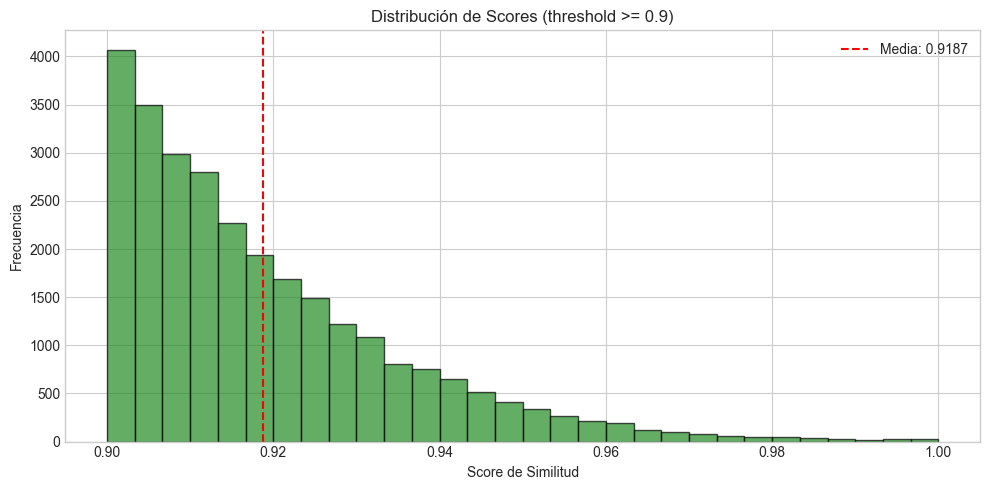


Estadísticas de scores filtrados:
  Media:   0.9187
  Mediana: 0.9141
  Min:     0.9000
  Max:     1.0000


In [17]:
# Distribución de scores
fig, ax = plt.subplots(figsize=(10, 5))

ax.hist(df_output['Score Similitud (0,1)'], bins=30, edgecolor='black', alpha=0.7, color='forestgreen')
ax.axvline(df_output['Score Similitud (0,1)'].mean(), color='red', linestyle='--', 
          label=f"Media: {df_output['Score Similitud (0,1)'].mean():.4f}")
ax.set_xlabel('Score de Similitud')
ax.set_ylabel('Frecuencia')
ax.set_title(f'Distribución de Scores (threshold >= {THRESHOLD})')
ax.legend()
plt.tight_layout()
plt.show()

print(f"\nEstadísticas de scores filtrados:")
print(f"  Media:   {df_output['Score Similitud (0,1)'].mean():.4f}")
print(f"  Mediana: {df_output['Score Similitud (0,1)'].median():.4f}")
print(f"  Min:     {df_output['Score Similitud (0,1)'].min():.4f}")
print(f"  Max:     {df_output['Score Similitud (0,1)'].max():.4f}")

---
## 7. Exportar CSV

In [18]:
# Renombrar columna para formato exacto requerido
df_final = df_output.rename(columns={'ITE_ITEM_TITLE_2': 'ITE_ITEM_TITLE'})

# Para mantener nombres de columnas distintos en el CSV
df_final.columns = ['ITE_ITEM_TITLE', 'ITE_ITEM_TITLE_2', 'Score Similitud (0,1)']

# Guardar
OUTPUT_FILE = 'output_similitud.csv'
df_output.to_csv(OUTPUT_FILE, index=False)

print(f"Archivo guardado: {OUTPUT_FILE}")
print(f"Total de pares: {len(df_output):,}")

Archivo guardado: output_similitud.csv
Total de pares: 27,783


In [ ]:
import pandas as pd
pd.set_option('display.max_colwidth', None)  # muestra todo el texto de las celdas
print("\nVista previa del archivo de salida:")
df_output.head(10)


Vista previa del archivo de salida:


,ITE_ITEM_TITLE,ITE_ITEM_TITLE_2,"Score Similitud (0,1)"
0,Sapatenis Masculino Da Polo Lançamento 30% Off,Sapatenis Masculino Da Polo Lançamento 30% Off,1.0
1,Tênis Slip On,Tênis Slip On,1.0
2,Tv Portátil Tomate Mtm-808 Led 8 Polegadas 100v/240v,Tv Portátil Tomate Mtm-808 Led 8 Polegadas 100v/240v,1.0
3,Tenis D&g Milano,Tenis D & G Milano,1.0
4,Tênis Feminino Flatform Espadrille Beira Rio - 4232100,Tênis Feminino Flatform Espadrille Beira Rio 4232100,1.0
5,Tênis Olympikus Saga Feminino Marinho,Tênis Olympikus Saga Feminino - Marinho,1.0
6,Sapatênis Tênis Masculino Couro Legítimo Cano Alto Confort,Sapatênis Tênis Masculino Couro Legítimo Cano Alto Confort,1.0
7,Tênis Converse All Star Cano Alto,Tênis Converse All Star Cano Alto,1.0
8,Tênis - Schutz,Tênis Schutz.,1.0
9,Tênis Plataforma Jeans Feminino Com Zíper-pronta Entrega,Tênis Plataforma Jeans Feminino Com Zíper Pronta Entrega,1.0


---
## Resumen

In [20]:
print("="*60)
print("RESUMEN DE RESULTADOS")
print("="*60)
print(f"\nDataset:")
print(f"  - Productos evaluados: {len(df_test):,}")
print(f"  - Total pares posibles: {n*(n-1)//2:,}")

print(f"\nModelo:")
print(f"  - SBERT (paraphrase-multilingual-mpnet-base-v2)")
print(f"  - Dimensión embeddings: {embeddings.shape[1]}")

print(f"\nResultados:")
print(f"  - Threshold: {THRESHOLD}")
print(f"  - Pares encontrados: {len(df_output):,}")
print(f"  - Score máximo: {df_output['Score Similitud (0,1)'].max():.4f}")
print(f"  - Score mínimo: {df_output['Score Similitud (0,1)'].min():.4f}")

print(f"\nArchivo de salida:")
print(f"  - {OUTPUT_FILE}")
print("="*60)

RESUMEN DE RESULTADOS

Dataset:
  - Productos evaluados: 10,000
  - Total pares posibles: 49,995,000

Modelo:
  - SBERT (paraphrase-multilingual-mpnet-base-v2)
  - Dimensión embeddings: 768

Resultados:
  - Threshold: 0.9
  - Pares encontrados: 27,783
  - Score máximo: 1.0000
  - Score mínimo: 0.9000

Archivo de salida:
  - output_similitud.csv
